In [1]:
import os
os.chdir('../')

from flearn.common.dataset import read_data

In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

In [3]:
train_dir='data/vehicle/train/'
test_dir='data/vehicle/test/'

In [4]:
clients, groups, train_data, test_data = read_data(train_dir, test_dir, True)

# Distribution of target - Vehicle

In [5]:
count_label = []
for key, val in train_data.items():
    y = val['y']
    pos = (y == 1).sum().item()
    neg = len(y) - pos
    count_label.append(
    {
        'client': key,
        'pos': pos,
        'neg': neg
    })

In [6]:
df = pd.DataFrame(count_label)

Text(0.5, 0, 'Clients')

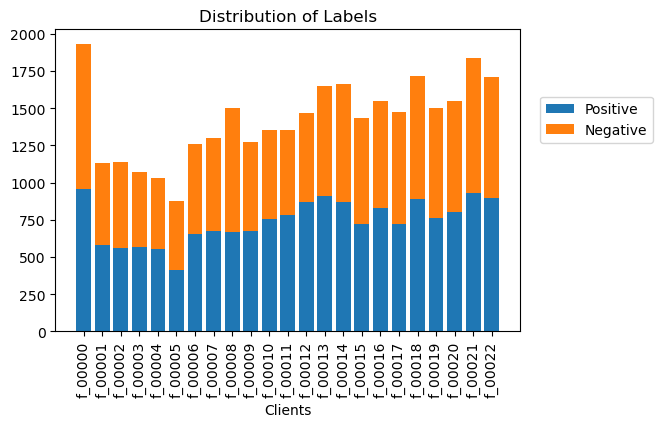

In [7]:
fig, ax = plt.subplots()
plt.xticks(df.index, df.client, rotation='vertical')
ax.bar(df.index, df.pos, label='Positive')
ax.bar(df.index, df.neg, label='Negative', bottom=df.pos)
ax.legend(bbox_to_anchor=(1.3, 0.8))
ax.set_title("Distribution of Labels")
ax.set_xlabel('Clients')

# Fairness Violation

In [8]:
from viz.utils import *
from main import run_vehicle

In [85]:
def get_fairness(df):
    fairness = []
    for r in df['round'].unique():
        res = df[(df['round']==r) & (df['c_name'] != 'global')]
        min_max = res.test_acc.max() - res.test_acc.min()
        std = res.test_acc.std()
        gi = gini(res.test_acc.tolist())
        acc = df[df['c_name'] == 'global']['test_acc'].tolist()[-1]
        fairness.append({
            'round': r,
            'min_max': min_max,
            'std':std,
            'gini': gi,
            'acc': acc
        })
    return fairness

In [86]:
def train_model(train_dir='data/vehicle/train/',
                test_dir='data/vehicle/test/',
                method_name='DL_FedAvgServer',
                s=0.5,
                q=5.0
               ):
    configs={
        # Model configs
        'layer_sizes': [100,1], 'act_funcs': ['none'],
        'dataset_name': 'vehicle',
        'method_name': method_name,
        # Server configs
        'num_rounds': 20,
        'pct_client_per_round': 10.0/23.0,
        'num_epochs': 1,
        'batch_size': 64,
        'lr': 0.01,
        's': s,
        'q': q,
        'disable_tqdm':False
    }

    server, clients = run_vehicle(train_dir, test_dir, configs, report=False)
    # df = get_results_from_server(server)
    return server, clients

In [87]:
from sklearn.model_selection import ParameterGrid

grid = [
    {
        "method_name": ['QFedAvgServer'],
        'q': [0, 1, 2, 3, 4, 5]
    },
    {
        "method_name": ['DL_FedAvgServer'],
        's': [0, 0.5, 1, 3, 5]
    }
]

experiments = []

for params in list(ParameterGrid(grid)):
   
    server, clients = train_model(**params)
    df = get_results_from_server(server)
    fn = get_fairness(df)
    params.update(fn[-1])
    experiments.append(
        params
    )

  0%|          | 0/20 [00:00<?, ?it/s]/home/huypham/Projects/federate-learning/flearn/algo/server.py:353: RuntimeWarning: invalid value encountered in double_scalars
  clt.update_lambda(clt.get_lambda()/k)
100%|██████████| 20/20 [00:02<00:00,  6.98it/s]


In [88]:
exp = pd.DataFrame(experiments)

In [89]:
exp

,method_name,q,round,min_max,std,gini,acc,s
0,QFedAvgServer,0.0,20,0.146417,0.032908,0.018872,0.923703,NaN
1,QFedAvgServer,1.0,20,0.109529,0.027132,0.015856,0.925990,NaN
2,QFedAvgServer,2.0,20,0.158205,0.032674,0.018355,0.925258,NaN
3,QFedAvgServer,3.0,20,0.099557,0.025378,0.014756,0.927180,NaN
4,QFedAvgServer,4.0,20,0.140366,0.032846,0.019031,0.923154,NaN
5,QFedAvgServer,5.0,20,0.133494,0.031630,0.018018,0.922971,NaN
6,DL_FedAvgServer,NaN,19,0.145763,0.030375,0.017053,0.925899,0.0
7,DL_FedAvgServer,NaN,19,0.126942,0.030574,0.018080,0.922240,0.5
8,DL_FedAvgServer,NaN,19,0.154681,0.032527,0.018753,0.923978,1.0
9,DL_FedAvgServer,NaN,19,0.124725,0.025880,0.014516,0.929101,3.0


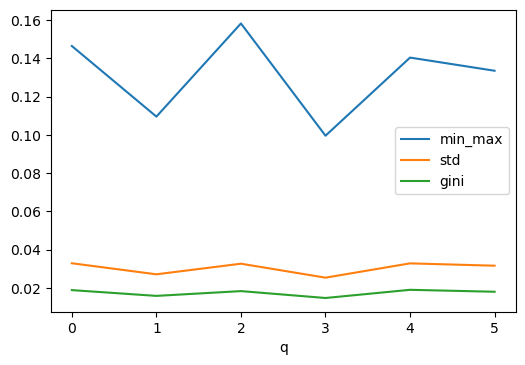

In [91]:
# QFed
df = exp[exp['method_name'] == 'QFedAvgServer'][['q', 'min_max', 'std', 'gini']]
df.plot(x='q')

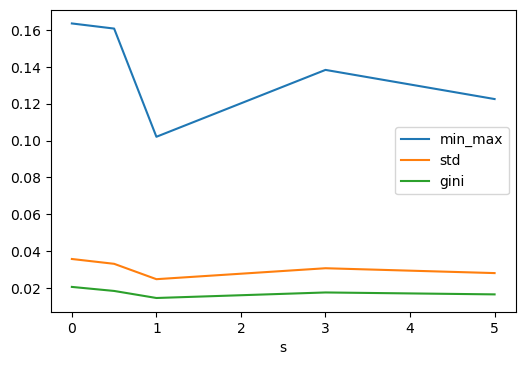

In [79]:
# QFed
df = exp[exp['method_name'] == 'DL_FedAvgServer'][['s', 'min_max', 'std', 'gini']]
df.plot(x='s')